# "Old" Data from the old space that the occupants inhabited -- Visualizations!

Clayton Miller
Feb 22, 2017

Extract data and analyze data according to Jovan's instructions:

```
First I will start with dates:
7th October till 15th October. According to data looks like 11th and 12th October were weekends although the calendar says 10th and 11th October. 

Sensor readings will have a few adjustments. I will go as they appear in the Grafana visualization tool.

Temperature [deg C] - no corrections
Relative Humidity [%] - no correction
CO [ppm] - no correction
CO2 [ppm] - I need to see you regarding this. I know that Starbuck had garbage reading. Ganzhi numerical values that appear when a cursor is over them are good but visualization is totally off. 
NO2 [ppm] - multiply with 0.378 to get NO2 [micrograms/m3]
Formaldehyde - this was garbage reading. Erase it!
Ozone [ppb] - no corrections
VOC [ppb] - no corrections
Particles [particles/liter] - we will correct this for exclusively PM 2.5 by: number measured x 0.008177 and you will have [micrograms/m3]
IR Wall Temperature - all values should be averaged by adding them all up (8 of them) and just divided by 8. If this is possible would be the best: take that averaged value and add value Clayton_temp.mean and divide them by 2. This should then be Operative Temperature [deg C]. If this is complicated just use an average of 8 values and call that operative temperature.
```

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from influxdb import DataFrameClient
import pytz
import seaborn as sns
import json
import datetime
import matplotlib.pyplot as plt

from pylab import *
from __future__ import division

In [3]:
allpoints = pd.read_csv("./extracted_data/old_space/bulk_data/AllParticleData.csv", header=[0,1], tupleize_cols=True, index_col=[0], parse_dates=True)
allpoints.columns = pd.MultiIndex.from_tuples(allpoints.columns)

In [4]:
allpoints.index = allpoints.index.tz_localize('GMT').tz_convert('Asia/Singapore')

In [5]:
allpoints.head()

CO    CO2      FORM       NO2        O3  \
                             CLETUS CLETUS    CLETUS    CLETUS    CLETUS   
2015-09-04 16:40:00+08:00       NaN    NaN       NaN       NaN       NaN   
2015-09-04 16:50:00+08:00       NaN    NaN       NaN       NaN       NaN   
2015-09-04 17:00:00+08:00  4.095077    0.0  0.022341  4.083458  4.102058   
2015-09-04 17:10:00+08:00  4.095551    0.0  0.023582  4.083813  4.101820   
2015-09-04 17:20:00+08:00       NaN    NaN       NaN       NaN       NaN   

                            PART       VOC    hum   temp CO2_11 ...      CO2  \
                          CLETUS    CLETUS CLETUS CLETUS  CO2_1 ...  TEKANAN   
2015-09-04 16:40:00+08:00    NaN       NaN    NaN    NaN    NaN ...      NaN   
2015-09-04 16:50:00+08:00    NaN       NaN    NaN    NaN    NaN ...      NaN   
2015-09-04 17:00:00+08:00    0.0  0.006053    NaN    NaN    NaN ...      NaN   
2015-09-04 17:10:00+08:00    0.0  0.006231    NaN    NaN    NaN ...      NaN   
2015-09-04 17:20:00+08:00    NaN       NaN    NaN    NaN    NaN ...      NaN   

                             FORM     NO2      O3    PART     VOC     hum  \
                          TEKANAN TEKANAN TEKANAN TEKANAN TEKANAN TEKANAN   
2015-09-04 16:40:00+08:00     NaN     NaN     NaN     NaN     NaN     NaN   
2015-09-04 16:50:00+08:00     NaN     NaN     NaN     NaN     NaN     NaN   
2015-09-04 17:00:00+08:00     NaN     NaN     NaN     NaN     NaN     NaN   
2015-09-04 17:10:00+08:00     NaN     NaN     NaN     NaN     NaN     NaN   
2015-09-04 17:20:00+08:00     NaN     NaN     NaN     NaN     NaN     NaN   

                             temp  VOC       
                          TEKANAN VOC1 VOC3  
2015-09-04 16:40:00+08:00     NaN  NaN  NaN  
2015-09-04 16:50:00+08:00     NaN  NaN  NaN  
2015-09-04 17:00:00+08:00     NaN  NaN  NaN  
2015-09-04 17:10:00+08:00     NaN  NaN  NaN  
2015-09-04 17:20:00+08:00     NaN  NaN  NaN  

[5 rows x 73 columns]

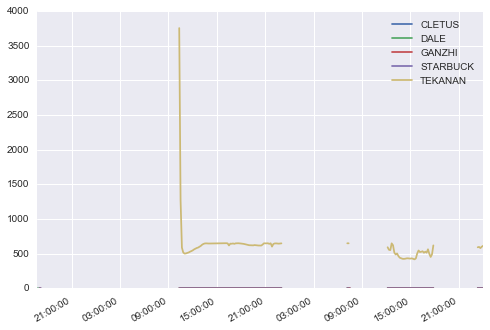

In [6]:
allpoints["CO2"].truncate(after='2015-09-07').plot()

## Clip the data to october

In [7]:
sns.set_style("whitegrid")

In [8]:
allpoints_oct = allpoints.truncate(before='2015-10-07', after='2015-10-15').dropna(axis=1, how='all').dropna(axis=0, how='all')

In [9]:
allpoints_sept = allpoints.truncate(before='2015-09-23', after='2015-09-26').dropna(axis=1, how='all').dropna(axis=0, how='all')

In [10]:
allpoints_septandoct = pd.concat([allpoints_sept, allpoints_oct]) 

In [11]:
#allpoints_septandoct.info()

Remove various sensors that have weird data as it has some weird data

Separate occupied vs. unoccupied

In [12]:
first = allpoints_septandoct.ix[allpoints_septandoct.index.indexer_between_time(datetime.time(0), datetime.time(7))]
last = allpoints_septandoct.ix[allpoints_septandoct.index.indexer_between_time(datetime.time(20), datetime.time(23))]

In [13]:
unoccupied = pd.concat([first,last], axis=0)#.info()

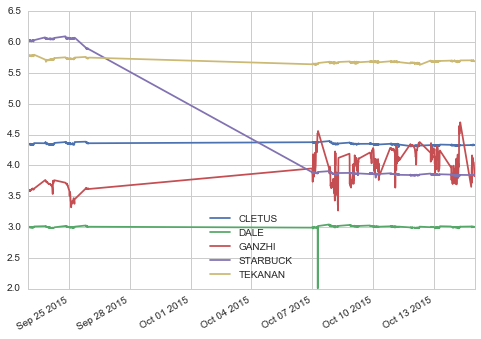

In [14]:
unoccupied['CO'].plot()

In [15]:
def plot_all_and_occupied(data, pointtype, excludedcol):
    pointdata = data[pointtype]
    if excludedcol != "none":
        pointdata = pointdata.drop(excludedcol, axis=1)
    #exclude weekend
    pointdata_weekday = pointdata[pointdata.index.dayofweek < 5]
    
    #get occupied
    pointdata_weekday_occupied = pointdata_weekday.ix[pointdata_weekday.index.indexer_between_time(datetime.time(9), datetime.time(17))] 
    
    #get unoccupied
    first = pointdata_weekday.ix[pointdata_weekday.index.indexer_between_time(datetime.time(0), datetime.time(6))]
    last = pointdata_weekday.ix[pointdata_weekday.index.indexer_between_time(datetime.time(21), datetime.time(23))]
    pointdata_weekday_unoccupied = pd.concat([first,last], axis=0).sort_index()
    
    pointdata.plot(figsize=(15,6), title="All Data");
    pointdata_weekday_occupied.plot(title="Working Hours",figsize=(15,6));
    pointdata_weekday_unoccupied.plot(title="Non-working Hours",figsize=(15,6));

    return pointdata, pointdata_weekday_occupied, pointdata_weekday_unoccupied

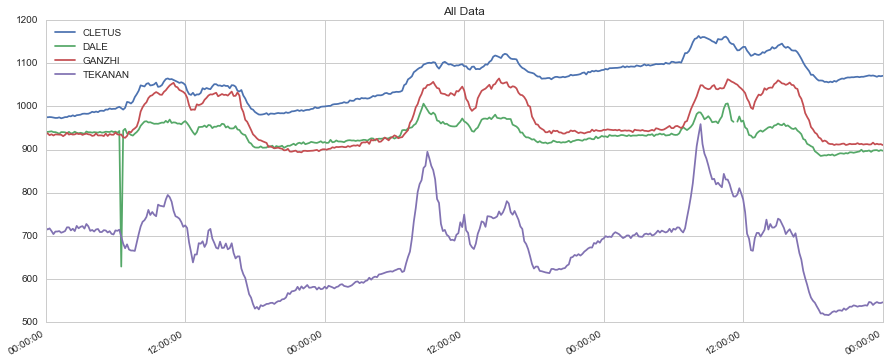

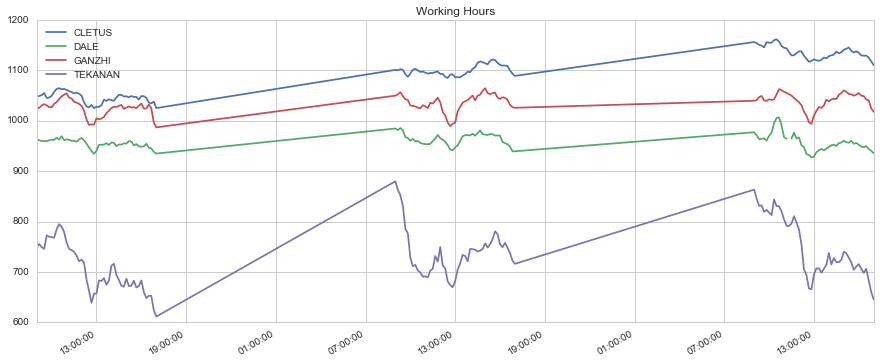

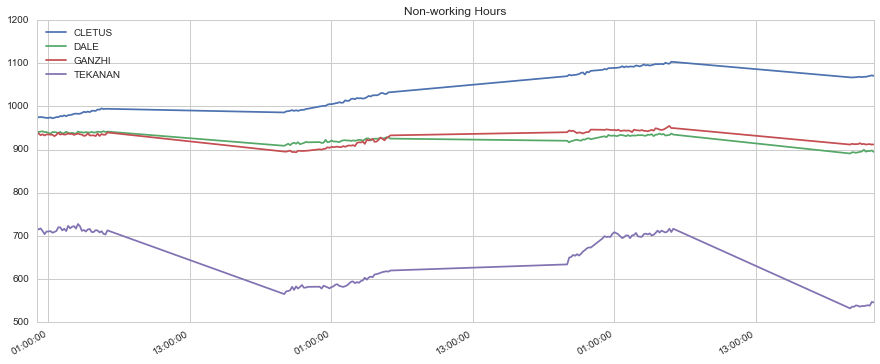

In [16]:
co2, co2_occupied, co2_unoccupied = plot_all_and_occupied(allpoints_oct.truncate(after='2015-10-10'), 'CO2', 'STARBUCK')

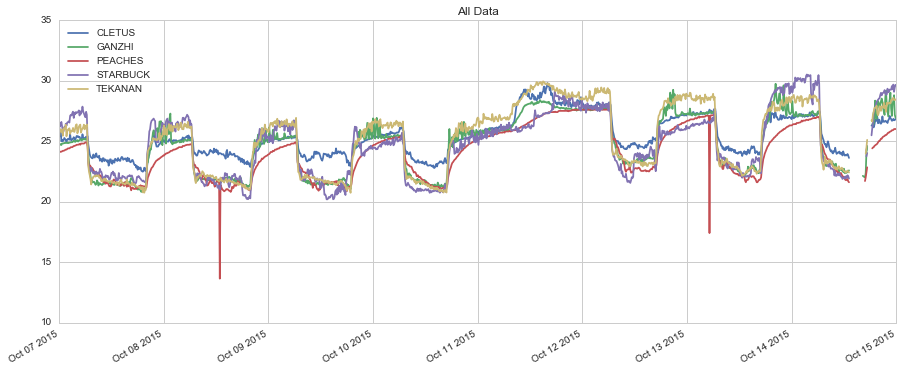

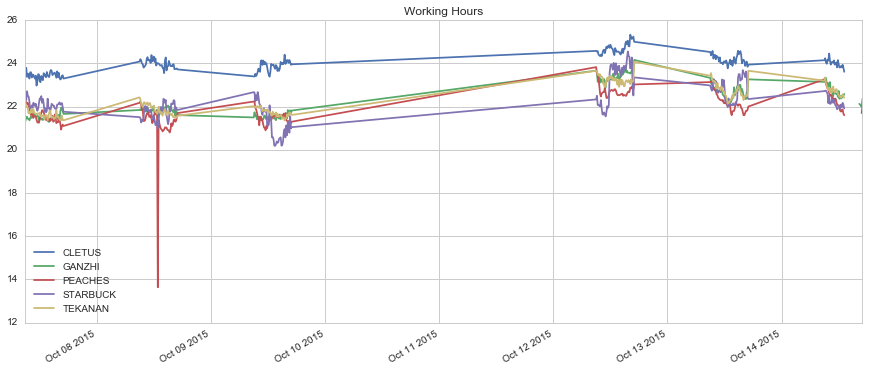

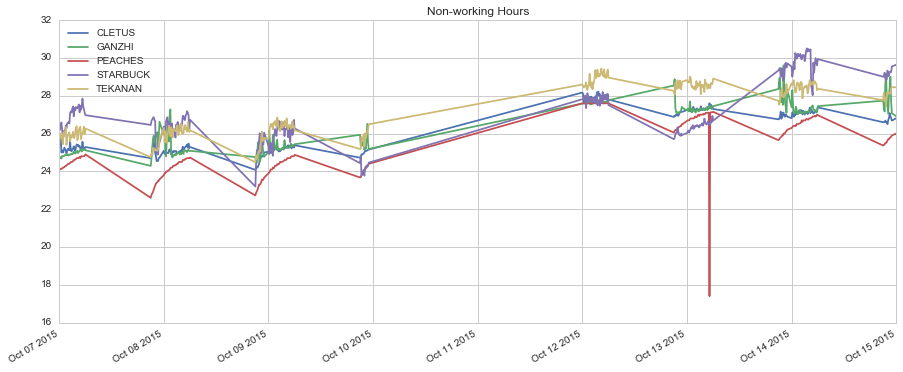

In [17]:
temp, temp_occupied, temp_unoccupied = plot_all_and_occupied(allpoints_oct, 'temp', ['DALE','Clayton','ERIC'])

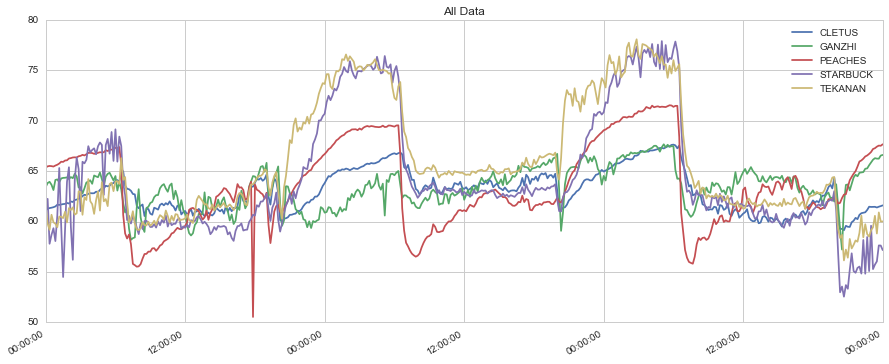

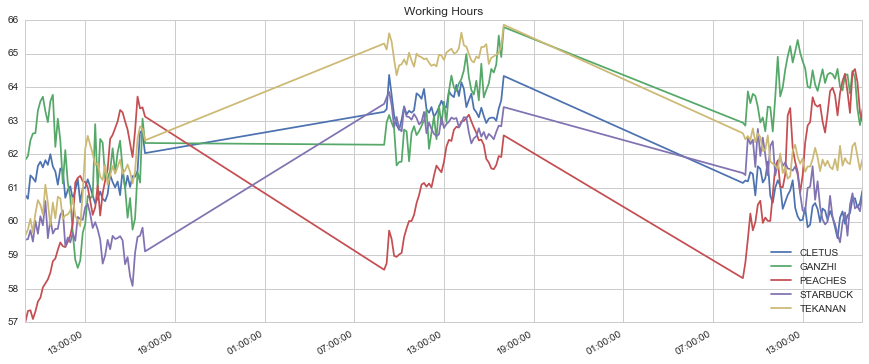

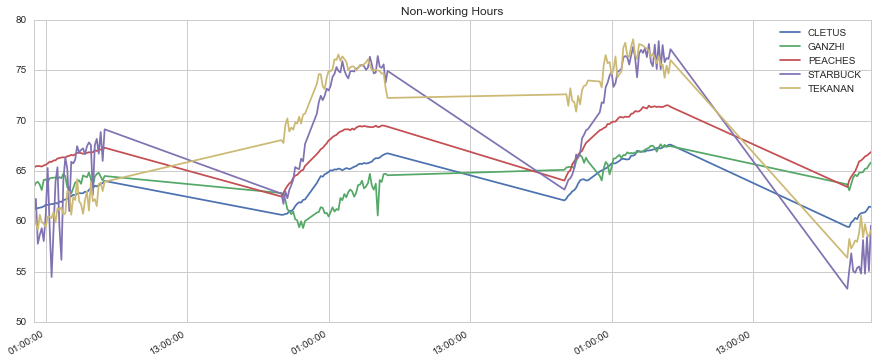

In [18]:
hum, hum_occupied, hum_unccupied = plot_all_and_occupied(allpoints_sept, 'hum', ['DALE','Clayton','ERIC'])

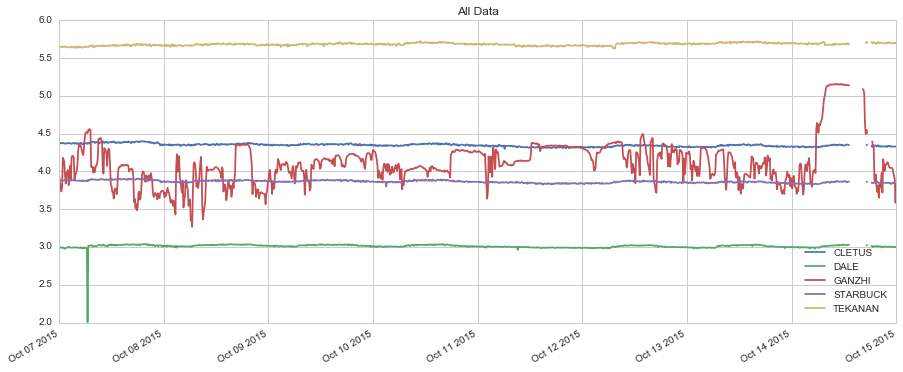

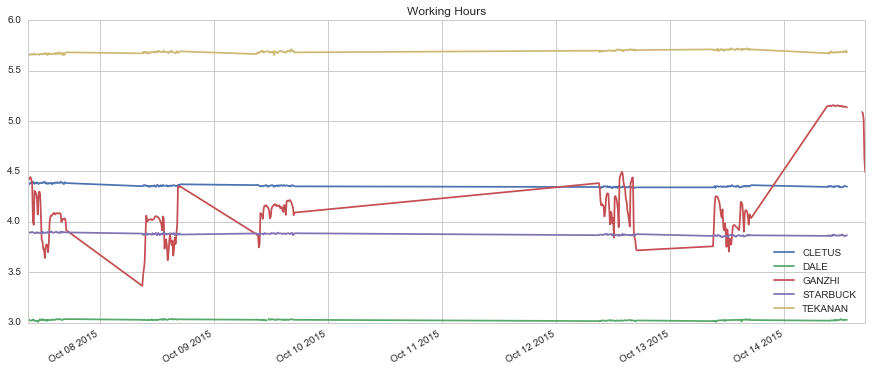

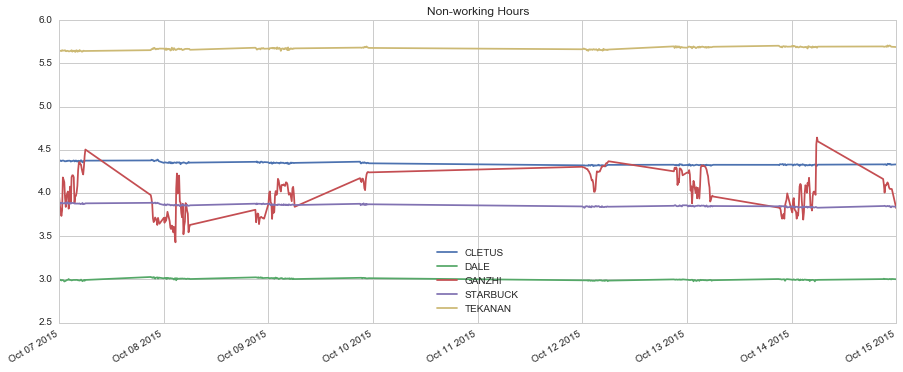

In [19]:
co, co_occupied, co_unoccupied = plot_all_and_occupied(allpoints_oct, 'CO', 'none')

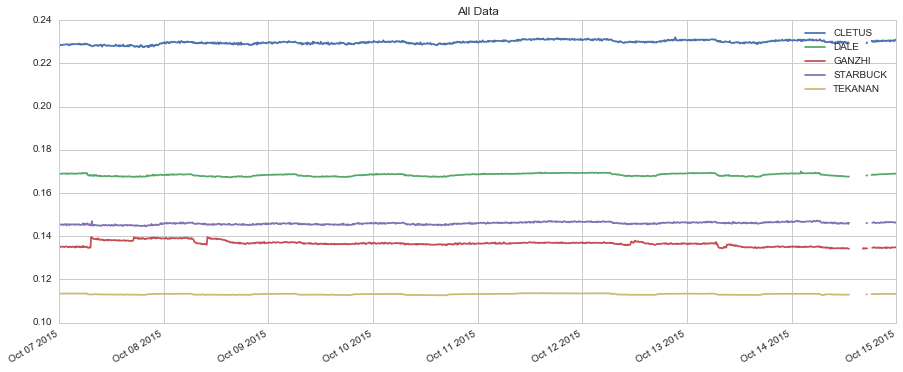

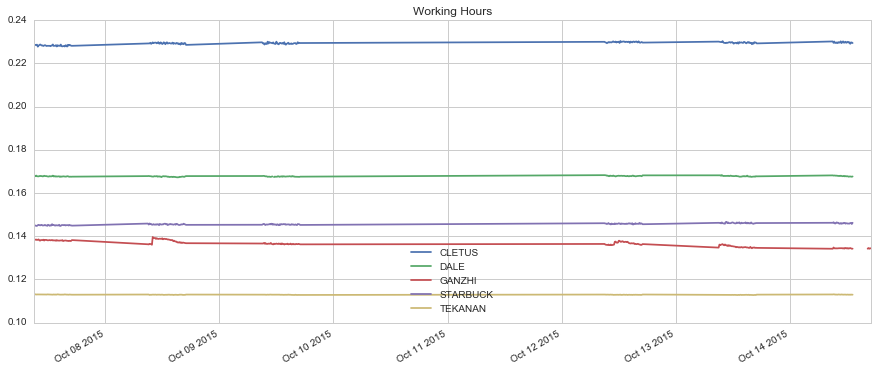

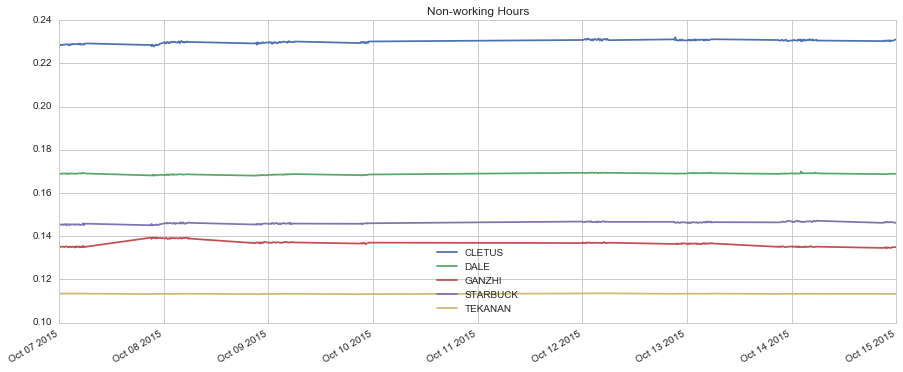

In [20]:
no, no_occupied, no_unoccupied = plot_all_and_occupied(allpoints_oct, 'NO2', 'none')

Multiple NO2 by 0.378 to get micrograms/m3

In [21]:
no, no_occupied, no_unoccupied = no*0.378, no_occupied*0.378, no_unoccupied*0.378

In [22]:
#allpoints

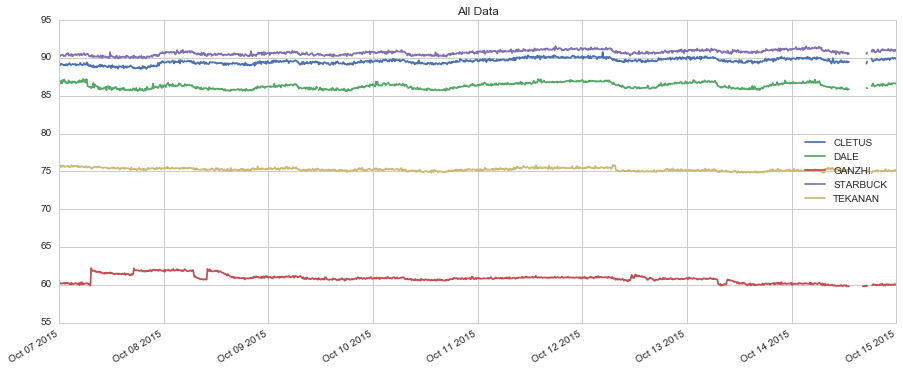

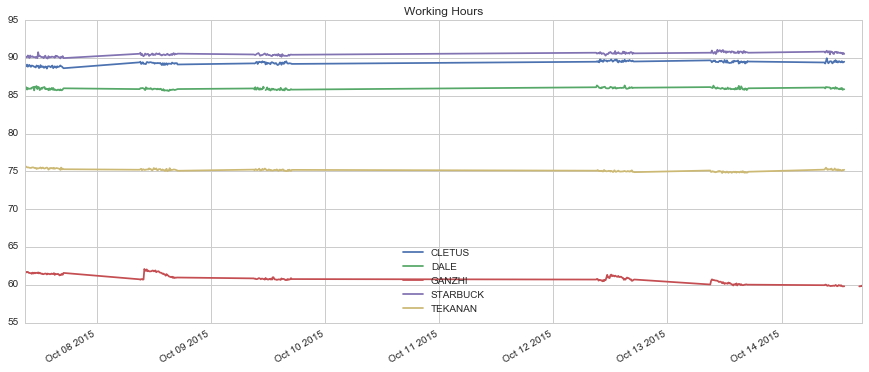

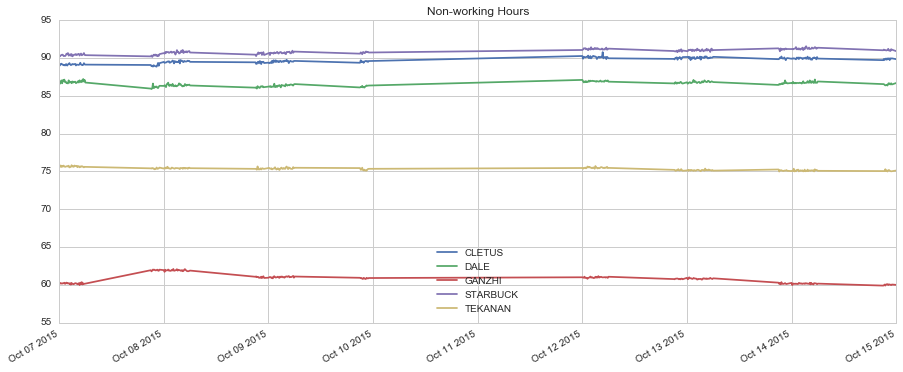

In [23]:
ozone, ozone_occupied, ozone_unoccupied = plot_all_and_occupied(allpoints_oct, 'O3', 'none')

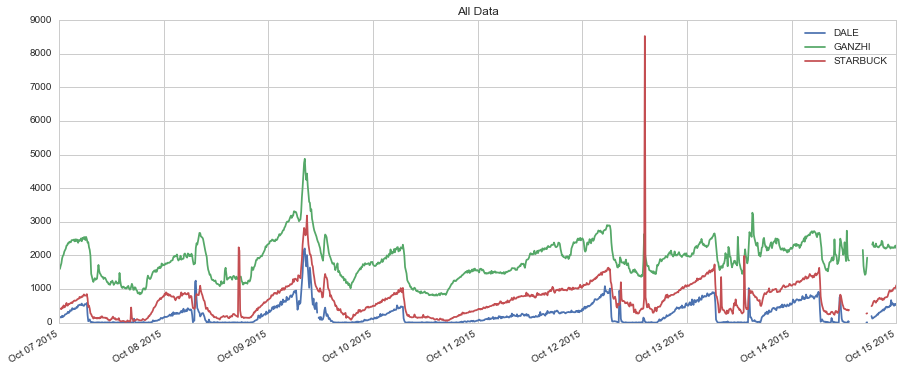

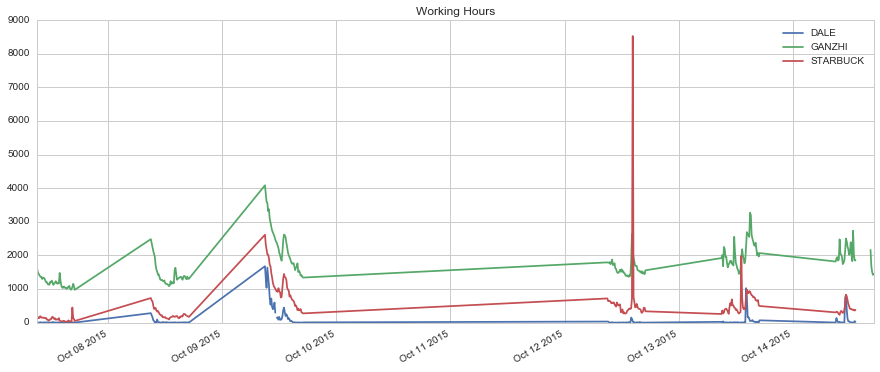

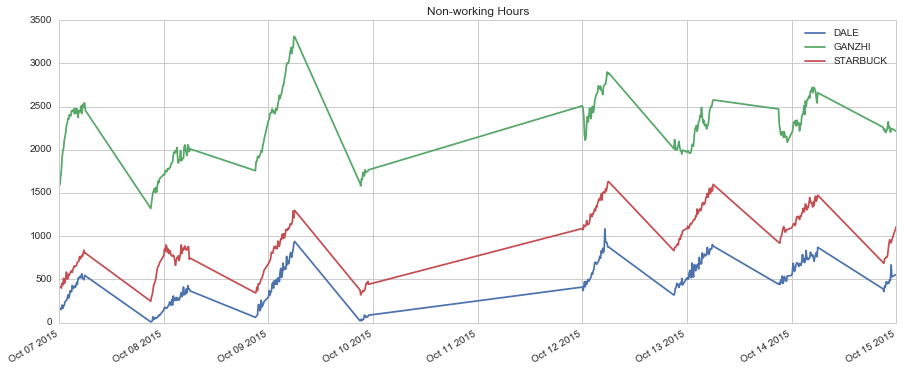

In [24]:
voc, voc_occupied, voc_unoccupied = plot_all_and_occupied(allpoints_oct, 'VOC', ['TEKANAN','CLETUS'])

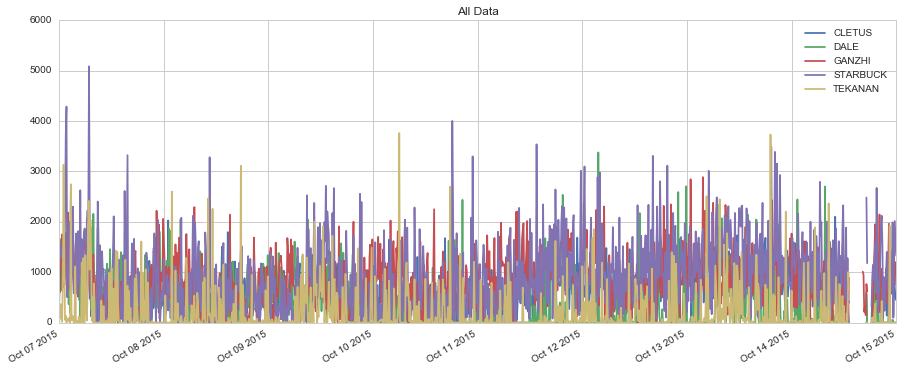

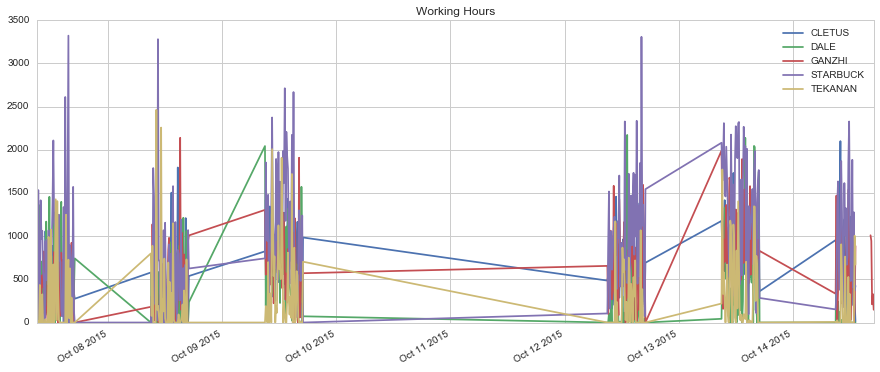

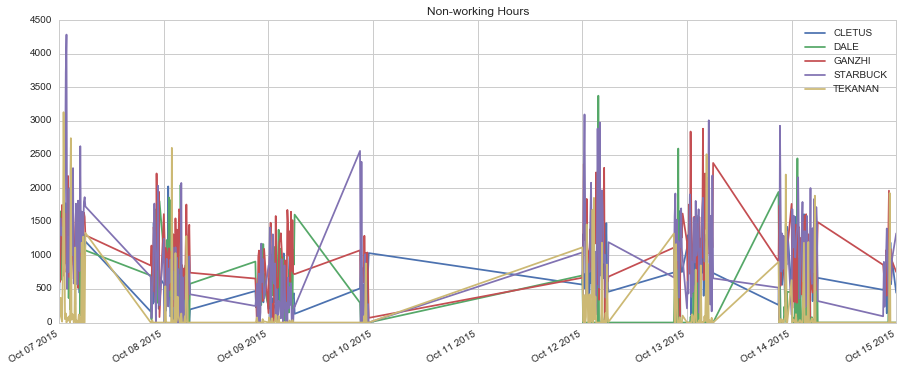

In [25]:
particles, particles_occupied, particles_unoccupied = plot_all_and_occupied(allpoints_oct, 'PART', 'none')

In [26]:
particles, particles_occupied, particles_unoccupied = particles*0.008177, particles_occupied*0.008177, particles_unoccupied*0.008177

In [27]:
irradiance_avg = (allpoints_oct['i1']+allpoints_oct['i2']+allpoints_oct['i3']+allpoints_oct['i4']+allpoints_oct['i5']
              +allpoints_oct['i6']+allpoints_oct['i7']+allpoints_oct['i8'])/8

In [28]:
#irradiance_avg

In [29]:
#allpoints_oct['temp']['Clayton'].resample('10min').mean()

In [30]:
#irradiance_avg['Clayton'].resample('10min').mean()

In [31]:
irradiance_avg_corrected = (irradiance_avg['Clayton'].resample('10min').mean() + allpoints_oct['temp']['Clayton'].resample('10min').mean())/2

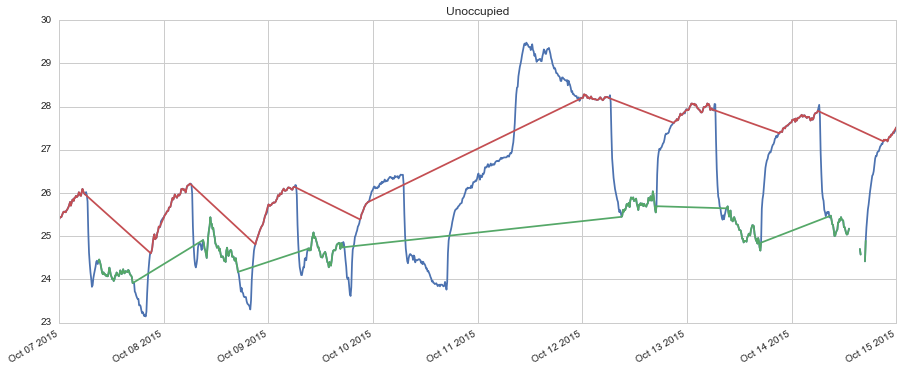

In [32]:
#exclude weekend
pointdata_weekday = irradiance_avg_corrected[irradiance_avg_corrected.index.dayofweek < 5]
    
#get occupied
IR_occupied = pointdata_weekday.ix[pointdata_weekday.index.indexer_between_time(datetime.time(9), datetime.time(17))]

first = pointdata_weekday.ix[pointdata_weekday.index.indexer_between_time(datetime.time(0), datetime.time(6))]
last = pointdata_weekday.ix[pointdata_weekday.index.indexer_between_time(datetime.time(21), datetime.time(23))]
IR_unoccupied = pd.concat([first,last], axis=0).sort_index()

irradiance_avg_corrected.plot(figsize=(15,6), title="All Data");
IR_occupied.plot(title="Occupied",figsize=(15,6));
IR_unoccupied.plot(title="Unoccupied",figsize=(15,6));

In [33]:
#IR_occupied

In [34]:
# opptemp = plot_values(IR_occupied, IR_unoccupied, temphum_name_mapping, "Temp [deg. C]", "BrBG")
IR_occupied = pd.DataFrame({'value':IR_occupied, 'Occupancy Type':'Working Hours', 'Zones':'Zone 3'})
IR_unoccupied = pd.DataFrame({'value':IR_unoccupied, 'Occupancy Type':'Non-working Hours', 'Zones':'Zone 3'})
IR_total = pd.concat([IR_occupied, IR_unoccupied], axis=0)
IR_total.to_csv("Oldspace_IR.csv")
#plt.title('Operative Room Air Temperature')

In [35]:
IR_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 595 entries, 2015-10-07 09:00:00+08:00 to 2015-10-15 00:00:00+08:00
Data columns (total 3 columns):
Occupancy Type    595 non-null object
Zones             595 non-null object
value             576 non-null float64
dtypes: float64(1), object(2)
memory usage: 18.6+ KB


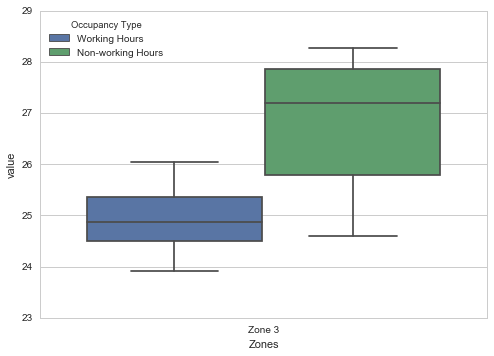

In [36]:
sns.boxplot(x=IR_total.Zones, y=IR_total.value, hue=IR_total["Occupancy Type"])

## Create boxplots

/Users/Clayton/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2125: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


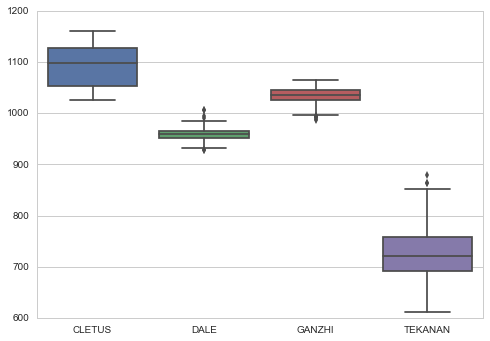

In [37]:
sns.boxplot(co2_occupied);

In [38]:
occupied = pd.melt(co2_occupied).dropna()
unoccupied = pd.melt(co2_unoccupied).dropna()
co2 = pd.DataFrame({"Occupied":occupied.value, "Unoccupied":unoccupied.value})

In [39]:
occupied.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 587 entries, 0 to 587
Data columns (total 2 columns):
variable    587 non-null object
value       587 non-null float64
dtypes: float64(1), object(1)
memory usage: 13.8+ KB


In [40]:
sns.set(style="ticks")

In [41]:
#co2

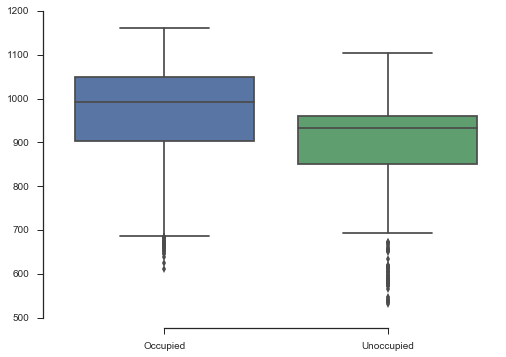

In [42]:
sns.boxplot(co2)
sns.despine(offset=10, trim=True)

## Look at Sept Data

In [43]:
def get_occ_and_unoocdata(data, pointtype, excludedcol):
    pointdata = data[pointtype]
    if excludedcol != "none":
        pointdata = pointdata.drop(excludedcol, axis=1)
    #exclude weekend
    pointdata_weekday = pointdata[pointdata.index.dayofweek < 5]
    
    #get occupied
    pointdata_weekday_occupied = pointdata_weekday.ix[pointdata_weekday.index.indexer_between_time(datetime.time(9), datetime.time(17))] 
    
    #get unoccupied
    first = pointdata_weekday.ix[pointdata_weekday.index.indexer_between_time(datetime.time(0), datetime.time(6))]
    last = pointdata_weekday.ix[pointdata_weekday.index.indexer_between_time(datetime.time(21), datetime.time(23))]
    pointdata_weekday_unoccupied = pd.concat([first,last], axis=0).sort_index()
    
#     pointdata.plot(figsize=(15,6), title="All Data");
#     pointdata_weekday_occupied.plot(title="Occupied",figsize=(15,6));
#     pointdata_weekday_unoccupied.plot(title="Unoccupied",figsize=(15,6));

    return pointdata, pointdata_weekday_occupied, pointdata_weekday_unoccupied

In [44]:
co2, co2_occupied, co2_unoccupied = get_occ_and_unoocdata(allpoints_sept.truncate(after='2015-10-10'), 'CO2', 'STARBUCK')
particles, particles_occupied, particles_unoccupied = get_occ_and_unoocdata(allpoints_sept, 'PART', 'none')
voc, voc_occupied, voc_unoccupied = get_occ_and_unoocdata(allpoints_sept, 'VOC', ['TEKANAN','CLETUS'])
ozone, ozone_occupied, ozone_unoccupied = get_occ_and_unoocdata(allpoints_sept, 'O3', 'none')
no, no_occupied, no_unoccupied = get_occ_and_unoocdata(allpoints_sept, 'NO2', 'none')
no, no_occupied, no_unoccupied = no*0.378, no_occupied*0.378, no_unoccupied*0.378
co, co_occupied, co_unoccupied = get_occ_and_unoocdata(allpoints_sept, 'CO', 'none')
hum, hum_occupied, hum_unccupied = get_occ_and_unoocdata(allpoints_sept, 'hum', ['DALE','Clayton','ERIC'])
temp, temp_occupied, temp_unoccupied = get_occ_and_unoocdata(allpoints_sept, 'temp', ['DALE','Clayton','ERIC'])

In [45]:
#pd.melt(temp_unoccupied)

In [46]:
temp.head()

,CLETUS,GANZHI,PEACHES,STARBUCK,TEKANAN
2015-09-23 00:00:00+08:00,24.664000,22.970000,24.200001,26.004999,25.949998
2015-09-23 00:10:00+08:00,24.716000,22.906000,24.220000,25.764000,26.625998
2015-09-23 00:20:00+08:00,24.736000,22.916000,24.299999,27.458002,26.808000
2015-09-23 00:30:00+08:00,24.747501,23.028000,24.339999,27.258000,26.550000
2015-09-23 00:40:00+08:00,24.809999,23.207999,24.400000,26.825999,26.684001


In [47]:
temphum_name_mapping = {"CLETUS":"Zone 1", "GANZHI":"Zone 2", "STARBUCK":"Zone 3", "TEKANAN":"Zone 4", "PEACHES":"Zone 5"}
co2_name_mapping = {"CLETUS":"Zone 1", "GANZHI":"Zone 2", "DALE":"Zone 3", "TEKANAN":"Zone 4", "PEACHES":"Zone 5"}
part_name_mapping = {"CLETUS":"Zone 1", "GANZHI":"Zone 2", "STARBUCK":"Zone 3","DALE":"Zone 3", "TEKANAN":"Zone 4"}
voc_name_mapping = {"GANZHI":"Zone 2", "DALE":"Zone 3", "STARBUCK":"Zone 3"}

In [48]:
temp.rename(columns=temphum_name_mapping).head()

,Zone 1,Zone 2,Zone 5,Zone 3,Zone 4
2015-09-23 00:00:00+08:00,24.664000,22.970000,24.200001,26.004999,25.949998
2015-09-23 00:10:00+08:00,24.716000,22.906000,24.220000,25.764000,26.625998
2015-09-23 00:20:00+08:00,24.736000,22.916000,24.299999,27.458002,26.808000
2015-09-23 00:30:00+08:00,24.747501,23.028000,24.339999,27.258000,26.550000
2015-09-23 00:40:00+08:00,24.809999,23.207999,24.400000,26.825999,26.684001


In [49]:
def rename_and_melt(df, mapping, labelname):
    df = df.rename(columns=mapping)
    df = df.sort_index(axis=1)
    df = pd.melt(df)
    df['Schedule'] = labelname
    return df 

In [50]:
def flatten_and_merge(occupied, unoccupied, mapping, unitname):
    occupied = rename_and_melt(occupied, mapping, labelname="Working Hours")
    unoccupied = rename_and_melt(unoccupied, mapping, labelname="Non-working Hours")
    total = pd.concat([occupied, unoccupied])
    total['unit'] = unitname
    total.columns = ["Zones", "Value", "Occupancy Type", "Unit"]
    return total

In [51]:
temp = flatten_and_merge(temp_occupied, temp_unoccupied, temphum_name_mapping, "Temp [deg. C]")

In [52]:
temp.head()

,Zones,Value,Occupancy Type,Unit
0,Zone 1,21.676001,Working Hours,Temp [deg. C]
1,Zone 1,21.712000,Working Hours,Temp [deg. C]
2,Zone 1,21.430001,Working Hours,Temp [deg. C]
3,Zone 1,21.466000,Working Hours,Temp [deg. C]
4,Zone 1,21.526000,Working Hours,Temp [deg. C]


In [53]:
def plot_values(occupied, unoccupied, mapping, pointtype, colormap):
    df = flatten_and_merge(occupied, unoccupied, mapping, pointtype)
    #fig.set_size_inches(7, 3)
    sns.boxplot(x=df.Zones, y=df["Value"], hue=df["Occupancy Type"], palette=colormap)
    return df

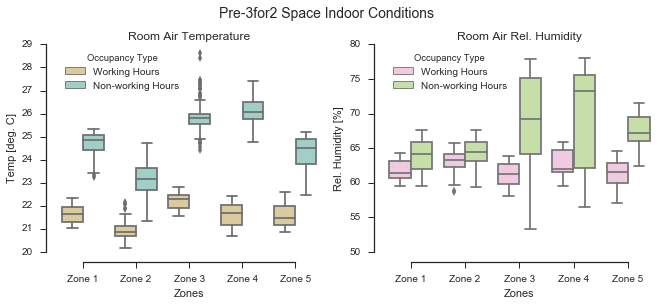

In [54]:
sns.set(style="ticks")
#fig, ax = plt.subplots()
#fig.set_size_inches(12, 4)
# fig = plt.figure(figsize=[12,4])

fig1 = plt.figure(figsize=[12,4])
fig1.suptitle("Pre-3for2 Space Indoor Conditions", fontsize=14, y=1.03)
gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)

# ax1 = plt.subplot2grid((1,4), (0,1))
ax1 = fig1.add_subplot(gs[:,1:45])
temp = plot_values(temp_occupied, temp_unoccupied, temphum_name_mapping, "Temp [deg. C]", "BrBG")
plt.title('Room Air Temperature')
plt.ylabel("Temp [deg. C]")

# ax2 = plt.subplot2grid((1,4), (0,2))
ax2 = fig1.add_subplot(gs[:,55:100])
hum = plot_values(hum_occupied, hum_unccupied, temphum_name_mapping, "Rel. Humidity [%]", "PiYG")
plt.title('Room Air Rel. Humidity')
plt.ylabel("Rel. Humidity [%]")

# ax3 = plt.subplot2grid((1,4), (0,3))
# co2 = plot_values(co2_occupied, co2_unoccupied, co2_name_mapping, "CO2 [ppm]", "PuOr")
# plt.title('Room Air CO2')
# plt.ylabel("CO2 [ppm]")

sns.despine(offset=10, trim=True)
# plt.tight_layout()
plt.savefig("./figures/OldSpace_TempHum.png", bbox_inches='tight')

In [55]:
def plot_values_indiv(occupied, unoccupied, mapping, pointtype, colormap, titlename, filename):
    fig, ax = plt.subplots()
#     plt.rcParams["figure.figsize"] = (3,3)
    df = flatten_and_merge(occupied, unoccupied, mapping, pointtype)
    fig.set_size_inches(4, 4)
    sns.boxplot(x=df.Zones, y=df["Value"], hue=df["Occupancy Type"], palette=colormap)
    plt.title(titlename)
    plt.ylabel(pointtype)
    sns.despine(offset=10, trim=True)
    plt.savefig("./figures/"+filename, bbox_inches='tight')
    df.to_csv("./extracted_data/old_space/targeted_data/"+titlename+".csv")
    return df

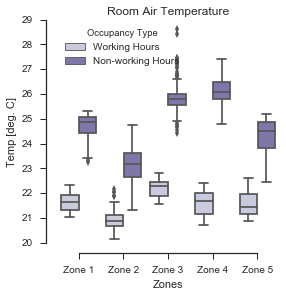

In [57]:
temp = plot_values_indiv(temp_occupied, temp_unoccupied, temphum_name_mapping, "Temp [deg. C]", "Purples","Room Air Temperature","OldSpaceIAQ_RoomAirTemp.pdf")

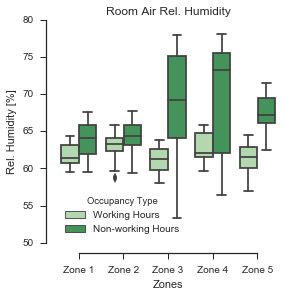

In [59]:
hum = plot_values_indiv(hum_occupied, hum_unccupied, temphum_name_mapping, "Rel. Humidity [%]", "Greens",'Room Air Rel. Humidity',"OldSpaceIAQ_RoomAirHum.pdf")

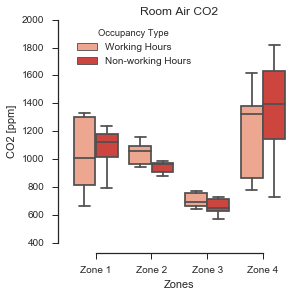

In [60]:
co2 = plot_values_indiv(co2_occupied, co2_unoccupied, co2_name_mapping, "CO2 [ppm]", "Reds",'Room Air CO2',"OldSpaceIAQ_RoomAirCO2.pdf")

In [61]:
particles = particles*0.008177
particles_occupied = particles_occupied*0.008177
particles_unoccupied = particles_unoccupied*0.008177

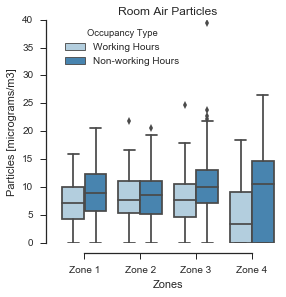

In [64]:
part = plot_values_indiv(particles_occupied, particles_unoccupied[particles_unoccupied<10000], part_name_mapping, "Particles [micrograms/m3]", "Blues","Room Air Particles","OldSpaceIAQ_RoomAirPart.pdf")

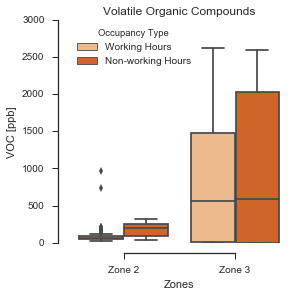

In [65]:
voc = plot_values_indiv(voc_occupied, voc_unoccupied, voc_name_mapping, "VOC [ppb]", "Oranges","Volatile Organic Compounds","OldSpaceIAQ_VOC.pdf")

In [331]:
voc.head()

,Zones,Value,Occupancy Type,Unit
0,Zone 2,194.299661,Working Hours,VOC [ppb]
1,Zone 2,162.279579,Working Hours,VOC [ppb]
2,Zone 2,181.293023,Working Hours,VOC [ppb]
3,Zone 2,173.204553,Working Hours,VOC [ppb]
4,Zone 2,213.202517,Working Hours,VOC [ppb]


In [332]:
IR_total = IR_total.reset_index(drop=True)

In [333]:
IR_total["Unit"] = "Operative Temp. [deg. C]"

In [334]:
IR_total.head()

,Occupancy Type,Zones,value,Unit
0,Working Hours,Zone 3,24.405000,Operative Temp. [deg. C]
1,Working Hours,Zone 3,24.459000,Operative Temp. [deg. C]
2,Working Hours,Zone 3,24.407361,Operative Temp. [deg. C]
3,Working Hours,Zone 3,24.340125,Operative Temp. [deg. C]
4,Working Hours,Zone 3,24.245139,Operative Temp. [deg. C]


In [335]:
IR_total.columns = ["Occupancy Type","Zones","Value","Unit"]

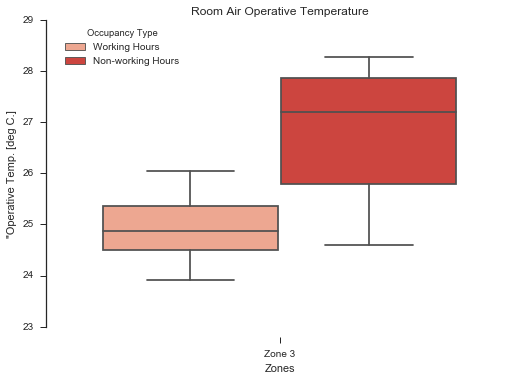

In [336]:
sns.boxplot(x=IR_total.Zones, y=IR_total["Value"], hue=IR_total["Occupancy Type"], palette="Reds")
plt.title('Room Air Operative Temperature')
plt.ylabel('"Operative Temp. [deg C.]')
sns.despine(offset=10, trim=True)
plt.savefig("./figures/OldSpaceIAQ_RoomAirOpTemp.pdf", bbox_inches='tight')
IR_total.to_csv("./extracted_data/old_space/targeted_data/OldSpaceIAQ_IR.csv")

In [337]:
# co2, co2_occupied, co2_unoccupied = get_occ_and_unoocdata(allpoints_sept.truncate(after='2015-10-10'), 'CO2', 'STARBUCK')
# particles, particles_occupied, particles_unoccupied = get_occ_and_unoocdata(allpoints_sept, 'PART', 'none')
# voc, voc_occupied, voc_unoccupied = get_occ_and_unoocdata(allpoints_sept, 'VOC', ['TEKANAN','CLETUS'])
# ozone, ozone_occupied, ozone_unoccupied = get_occ_and_unoocdata(allpoints_sept, 'O3', 'none')
# no, no_occupied, no_unoccupied = get_occ_and_unoocdata(allpoints_sept, 'NO2', 'none')
# no, no_occupied, no_unoccupied = no*0.378, no_occupied*0.378, no_unoccupied*0.378
# co, co_occupied, co_unoccupied = get_occ_and_unoocdata(allpoints_sept, 'CO', 'none')
# hum, hum_occupied, hum_unccupied = get_occ_and_unoocdata(allpoints_sept, 'hum', ['DALE','Clayton','ERIC'])
# temp, temp_occupied, temp_unoccupied = get_occ_and_unoocdata(allpoints_sept, 'temp', ['DALE','Clayton','ERIC'])

In [338]:
# plt.rcParams["figure.figsize"] = (4.5,3)
# temp = plot_values_indiv(temp_occupied, temp_unoccupied, temphum_name_mapping, "Temp [deg. C]", "BrBG")
# plt.title('Room Air Temperature')
# sns.despine(offset=10, trim=True)
# plt.savefig("OldSpaceIAQ_.pdf", bbox_inches='tight')

## Make subplots with all the values

In [339]:
def make_boxplot_data(occ_data, unocc_data):
    occupied = pd.melt(occ_data).dropna()
    unoccupied = pd.melt(unocc_data).dropna()
    plottedata = pd.DataFrame({"O":occupied.value, "U":unoccupied.value, "sensor":occupied.variable})
    return plottedata

In [340]:
occupied.head()

,variable,value
0,CLETUS,1048.438297
1,CLETUS,1049.170785
2,CLETUS,1050.977586
3,CLETUS,1055.079515
4,CLETUS,1045.215354


In [341]:
boxplot

<function matplotlib.pyplot.boxplot>

In [342]:
boxplotdata = make_boxplot_data(temp_occupied[temp_occupied>20], temp_unoccupied[temp_unoccupied>20])
boxplotdata = pd.melt(boxplotdata, id_vars='sensor')

In [343]:
boxplotdata.head()

,sensor,variable,value
0,CLETUS,O,21.676001
1,CLETUS,O,21.712000
2,CLETUS,O,21.430001
3,CLETUS,O,21.466000
4,CLETUS,O,21.526000


# Swarm plot

In [ ]:
#sns.swarmplot(x="variable", y="value", hue="sensor", data=boxplotdata)

# Total Aggregate Box Plots

ValueError: If using all scalar values, you must pass an index

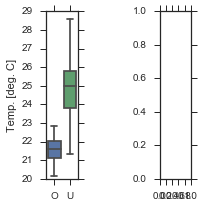

In [345]:
maxlimit = 12
plt.rcParams["figure.figsize"] = (8,3)

ax1 = plt.subplot2grid((1,maxlimit), (0,3))
sns.boxplot(make_boxplot_data(temp_occupied[temp_occupied>20], temp_unoccupied[temp_unoccupied>20]))
plt.ylabel("Temp. [deg. C]")

ax1 = plt.subplot2grid((1,maxlimit), (0,6))
sns.boxplot(pd.DataFrame({"O":IR_occupied, "U":IR_unoccupied}))
plt.ylabel("Operative Temp [deg. C]")

ax2 = plt.subplot2grid((1,maxlimit), (0,9))
sns.boxplot(make_boxplot_data(hum_occupied, hum_unccupied))
plt.ylabel("Humidity [%]")

sns.despine(offset=10, trim=True)
plt.savefig("./figures/OldSpace_temp_opptemp_humidity.pdf", bbox_inches='tight')

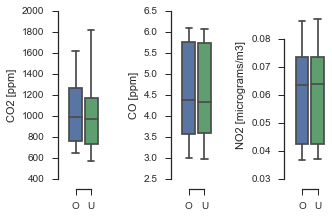

In [346]:
maxlimit = 12

ax1 = plt.subplot2grid((1,maxlimit), (0,3))
sns.boxplot(make_boxplot_data(co2_occupied, co2_unoccupied))
plt.ylabel("CO2 [ppm]")

ax2 = plt.subplot2grid((1,maxlimit), (0,6))
sns.boxplot(make_boxplot_data(co_occupied, co_unoccupied))
plt.ylabel("CO [ppm]")

ax3 = plt.subplot2grid((1,maxlimit), (0,9))
sns.boxplot(make_boxplot_data(no_occupied, no_unoccupied))
plt.ylabel("NO2 [micrograms/m3]")

sns.despine(offset=10, trim=True)
plt.savefig("./figures/OldSpace_CO2_CO_NO2.pdf", bbox_inches='tight')

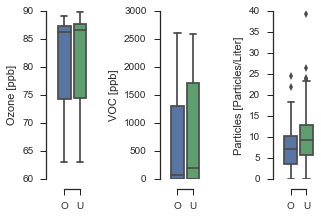

In [347]:
ax1 = plt.subplot2grid((1,maxlimit), (0,3))
sns.boxplot(make_boxplot_data(ozone_occupied, ozone_unoccupied))
plt.ylabel("Ozone [ppb]")

ax2 = plt.subplot2grid((1, maxlimit), (0,6))
sns.boxplot(make_boxplot_data(voc_occupied[voc_occupied<4000], voc_unoccupied[voc_unoccupied<4000]))
plt.ylabel("VOC [ppb]")

ax3 = plt.subplot2grid((1,maxlimit), (0,9))
sns.boxplot(make_boxplot_data(particles_occupied, particles_unoccupied[particles_unoccupied<10000]))
plt.ylabel("Particles [Particles/Liter]")

sns.despine(offset=10, trim=True)
plt.savefig("./figures/OldSpace_Ozone_VOC_Particles.pdf", bbox_inches='tight')